In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np
from trainer import *

from torchvision.transforms import v2

from deepr import *

import pickle

In [2]:


dtype=torch.float
print("VGG-block CNN ANN Trained on cifar10")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=256
data_path='./tmp/data/cifar10/'
num_classes = 10  # cifar has 10 output classes

# Define a transform
transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomResizedCrop(size=(32, 32),scale=(0.8,1), antialias=True),
            ])

transform2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,)),
            ])

cifar_train = datasets.CIFAR10(data_path, train=True, download=True,transform=transform1)
cifar_test = datasets.CIFAR10(data_path, train=False, download=True,transform=transform2)

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True,drop_last=False,pin_memory=True,num_workers=1)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=True,drop_last=False,pin_memory=True,num_workers=1)

print("Train batches:",len(train_loader))
print("Test batches:",len(test_loader))

VGG-block CNN ANN Trained on cifar10
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Train batches: 196
Test batches: 40


Useful to know what a convolutional layers output dimension is given by $n_{out}=\frac{n_{in}+2p-k}{s}+1$, 
with default padding=0 stride=1 $n_{out}=n_{in}-k+1$.
For max pool with defaults, $\lfloor\frac{n}{2}\rfloor$.

In [3]:
################ VGG9 Model #############################

# layer parameters

lr=5e-4

class Net(nn.Module):

    def __init__(self,c = None):
        super().__init__()

        self.loss = nn.CrossEntropyLoss()
        self.accuracy_metric = lambda logits, targets: (torch.argmax(logits,dim=1) == targets).sum().item() / targets.size(0)

        self.layers = nn.ModuleList([
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Linear(4096,256),
            nn.Dropout(0.5),
            nn.Linear(256,11),      
        ])

        

        self.neurons = nn.ModuleList([
            nn.ReLU()
        ] * len(self.layers))

        self.to(device)

        if c is not None:
            self.deepr = DeepR(self.layers,lr,[0,2,5,7,10,12,14,17,19],connectivity=c,device=device)
        
    def forward(self,x):
        
        for i in range(len(self.layers)):
            if(i==17): #need to flatten from pooling to Linear
                x= torch.flatten(x,start_dim=1)

            if i in {1,3,6,8,11,13,15}:
                x = self.layers[i](x)
                continue
            if(i==18):
                x = self.layers[i](x)
                continue

            x = self.neurons[i]( self.layers[i](x) )
        return x
    
###################################################################################
    








Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.47
Validation loss: 2.40
Validation accuracy: 9.77%
Training accuracy: 8.59%
----------------
Iteration: 400
Training loss: 0.83
Validation loss: 0.89
Validation accuracy: 68.75%
Training accuracy: 70.70%
----------------
Iteration: 800
Training loss: 0.58
Validation loss: 0.62
Validation accuracy: 81.25%
Training accuracy: 77.73%
----------------
Iteration: 1200
Training loss: 0.43
Validation loss: 0.63
Validation accuracy: 80.47%
Training accuracy: 87.50%
----------------
Iteration: 1600
Training loss: 0.34
Validation loss: 0.46
Validation accuracy: 85.94%
Training accuracy: 86.33%
----------------
Iteration: 2000
Training loss: 0.38
Validation loss: 0.43
Validation accuracy: 85.55%
Training accuracy: 85.55%
----------------
Iteration: 2400
Training loss: 0.36
Validation loss: 0.31
Validation accuracy: 88.28%
Training accuracy: 86.72%
----------------
Iteration: 2800
Training loss: 0.25
Validation loss: 0.30
Validation accuracy: 91.80%
Training accuracy:

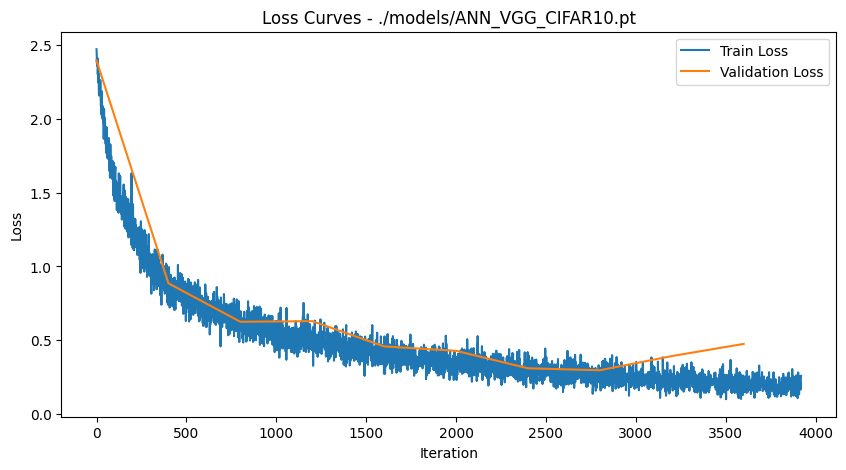

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 87.58%
----


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.44
Validation loss: 2.40
Validation accuracy: 11.33%
Training accuracy: 11.72%
----------------
Iteration: 400
Training loss: 0.87
Validation loss: 0.75
Validation accuracy: 72.27%
Training accuracy: 69.92%
----------------
Iteration: 800
Training loss: 0.70
Validation loss: 0.60
Validation accuracy: 78.91%
Training accuracy: 76.95%
----------------
Iteration: 1200
Training loss: 0.57
Validation loss: 0.57
Validation accuracy: 81.64%
Training accuracy: 83.98%
----------------
Iteration: 1600
Training loss: 0.39
Validation loss: 0.44
Validation accuracy: 85.94%
Training accuracy: 85.94%
----------------
Iteration: 2000
Training loss: 0.35
Validation loss: 0.35
Validation accuracy: 88.67%
Training accuracy: 89.06%
----------------
Iteration: 2400
Training loss: 0.34
Validation loss: 0.50
Validation accuracy: 85.16%
Training accuracy: 89.06%
----------------
Iteration: 2800
Training loss: 0.26
Validation loss: 0.42
Validation accuracy: 88.67%
Training accurac

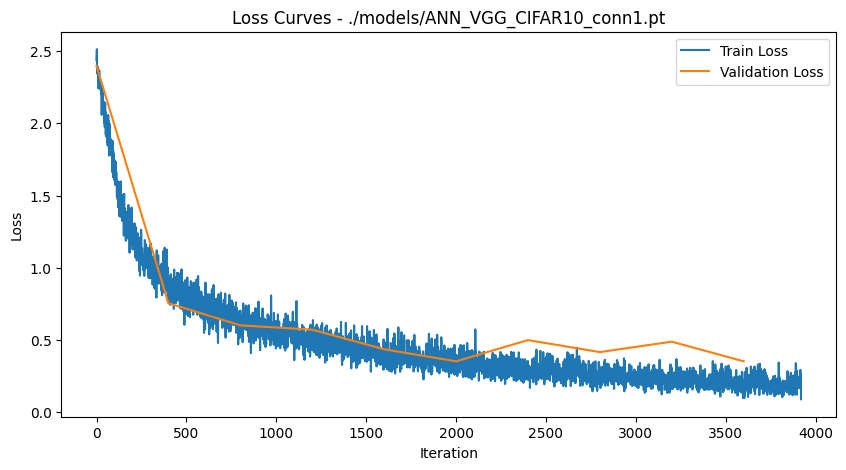

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 88.56%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.43
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 8.98%
----------------
Iteration: 400
Training loss: 0.75
Validation loss: 0.72
Validation accuracy: 76.95%
Training accuracy: 75.78%
----------------
Iteration: 800
Training loss: 0.51
Validation loss: 0.61
Validation accuracy: 77.73%
Training accuracy: 82.03%
----------------
Iteration: 1200
Training loss: 0.43
Validation loss: 0.54
Validation accuracy: 81.64%
Training accuracy: 86.72%
----------------
Iteration: 1600
Training loss: 0.55
Validation loss: 0.50
Validation accuracy: 83.20%
Training accuracy: 82.42%
----------------
Iteration: 2000
Training loss: 0.26
Validation loss: 0.43
Validation accuracy: 85.94%
Training accuracy: 91.80%
----------------
Iteration: 2400
Training loss: 0.32
Validation loss: 0.52
Validation accuracy: 84.77%
Training accuracy: 91.02%
----------------
Iteration: 2800
Training loss: 0.31
Validation loss: 0.51
Validation accuracy: 84.38%
Training accuracy:

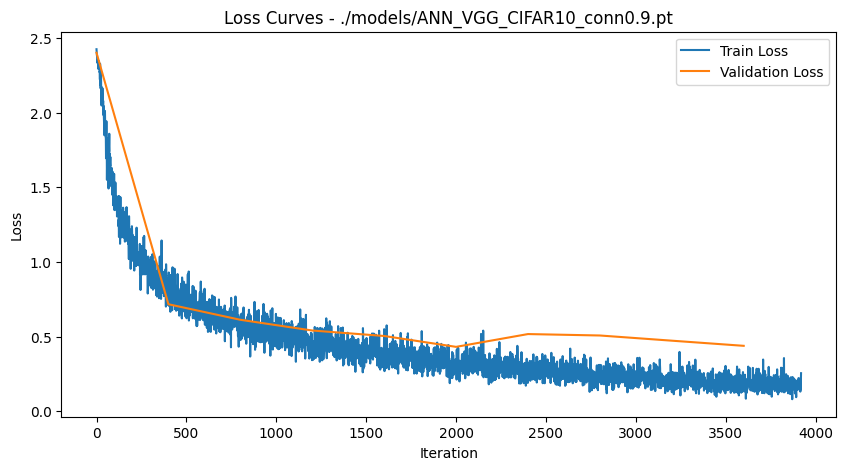

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 87.37%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.42
Validation loss: 2.39
Validation accuracy: 8.98%
Training accuracy: 9.77%
----------------
Iteration: 400
Training loss: 0.88
Validation loss: 0.94
Validation accuracy: 68.36%
Training accuracy: 70.31%
----------------
Iteration: 800
Training loss: 0.55
Validation loss: 0.74
Validation accuracy: 74.22%
Training accuracy: 79.30%
----------------
Iteration: 1200
Training loss: 0.33
Validation loss: 0.46
Validation accuracy: 84.38%
Training accuracy: 86.72%
----------------
Iteration: 1600
Training loss: 0.47
Validation loss: 0.48
Validation accuracy: 85.55%
Training accuracy: 85.94%
----------------
Iteration: 2000
Training loss: 0.29
Validation loss: 0.48
Validation accuracy: 85.55%
Training accuracy: 89.45%
----------------
Iteration: 2400
Training loss: 0.29
Validation loss: 0.41
Validation accuracy: 85.55%
Training accuracy: 91.02%
----------------
Iteration: 2800
Training loss: 0.24
Validation loss: 0.45
Validation accuracy: 85.55%
Training accuracy:

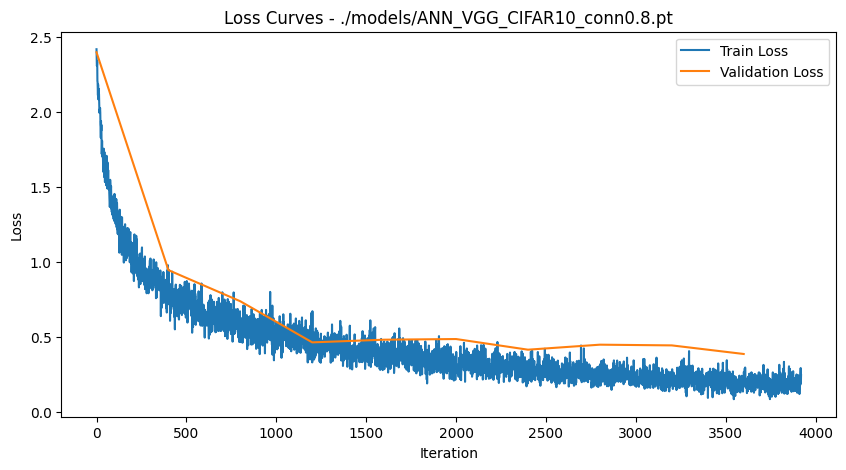

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 88.14%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.39
Validation loss: 2.40
Validation accuracy: 10.16%
Training accuracy: 13.67%
----------------
Iteration: 400
Training loss: 0.74
Validation loss: 0.81
Validation accuracy: 72.27%
Training accuracy: 76.56%
----------------
Iteration: 800
Training loss: 0.64
Validation loss: 0.57
Validation accuracy: 80.47%
Training accuracy: 77.34%
----------------
Iteration: 1200
Training loss: 0.52
Validation loss: 0.62
Validation accuracy: 82.42%
Training accuracy: 82.03%
----------------
Iteration: 1600
Training loss: 0.36
Validation loss: 0.46
Validation accuracy: 84.38%
Training accuracy: 87.50%
----------------
Iteration: 2000
Training loss: 0.40
Validation loss: 0.49
Validation accuracy: 86.72%
Training accuracy: 87.89%
----------------
Iteration: 2400
Training loss: 0.28
Validation loss: 0.56
Validation accuracy: 85.94%
Training accuracy: 89.84%
----------------
Iteration: 2800
Training loss: 0.25
Validation loss: 0.37
Validation accuracy: 88.28%
Training accurac

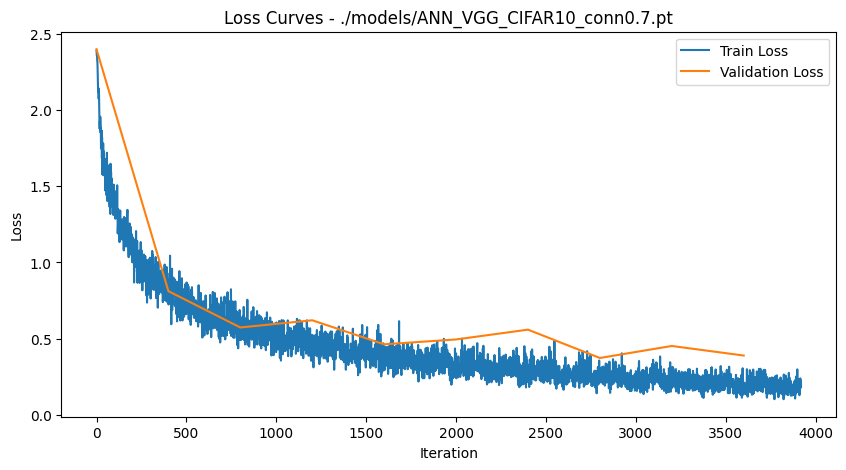

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 87.92%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 8.59%
Training accuracy: 9.77%
----------------
Iteration: 400
Training loss: 0.75
Validation loss: 0.75
Validation accuracy: 72.66%
Training accuracy: 73.44%
----------------
Iteration: 800
Training loss: 0.53
Validation loss: 0.77
Validation accuracy: 75.00%
Training accuracy: 81.25%
----------------
Iteration: 1200
Training loss: 0.39
Validation loss: 0.50
Validation accuracy: 82.81%
Training accuracy: 87.89%
----------------
Iteration: 1600
Training loss: 0.44
Validation loss: 0.52
Validation accuracy: 83.59%
Training accuracy: 83.98%
----------------
Iteration: 2000
Training loss: 0.28
Validation loss: 0.33
Validation accuracy: 85.94%
Training accuracy: 91.41%
----------------
Iteration: 2400
Training loss: 0.35
Validation loss: 0.58
Validation accuracy: 83.20%
Training accuracy: 89.45%
----------------
Iteration: 2800
Training loss: 0.25
Validation loss: 0.52
Validation accuracy: 83.98%
Training accuracy:

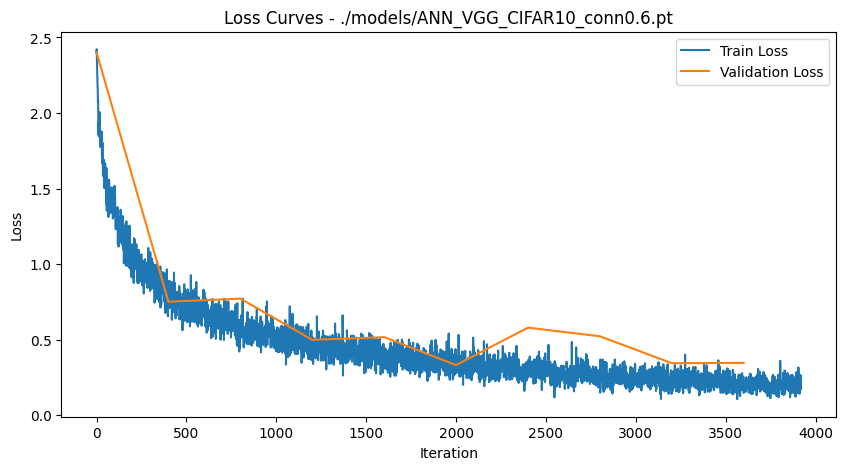

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 87.05%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 11.33%
Training accuracy: 11.72%
----------------
Iteration: 400
Training loss: 0.78
Validation loss: 1.05
Validation accuracy: 66.80%
Training accuracy: 74.61%
----------------
Iteration: 800
Training loss: 0.55
Validation loss: 0.63
Validation accuracy: 76.95%
Training accuracy: 78.52%
----------------
Iteration: 1200
Training loss: 0.50
Validation loss: 0.42
Validation accuracy: 86.72%
Training accuracy: 83.20%
----------------
Iteration: 1600
Training loss: 0.51
Validation loss: 0.53
Validation accuracy: 83.59%
Training accuracy: 82.42%
----------------
Iteration: 2000
Training loss: 0.30
Validation loss: 0.49
Validation accuracy: 85.16%
Training accuracy: 90.23%
----------------
Iteration: 2400
Training loss: 0.34
Validation loss: 0.50
Validation accuracy: 83.98%
Training accuracy: 89.06%
----------------
Iteration: 2800
Training loss: 0.25
Validation loss: 0.48
Validation accuracy: 87.11%
Training accurac

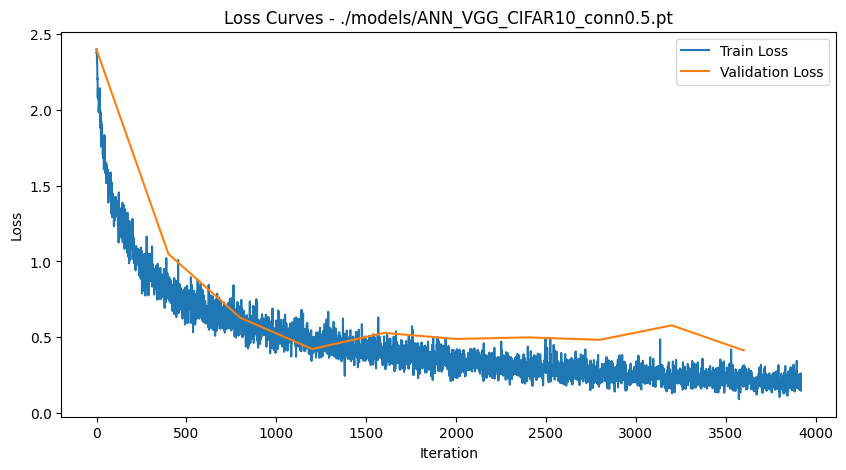

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 87.04%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.39
Validation loss: 2.40
Validation accuracy: 8.59%
Training accuracy: 7.81%
----------------
Iteration: 400
Training loss: 0.95
Validation loss: 0.72
Validation accuracy: 77.34%
Training accuracy: 68.36%
----------------
Iteration: 800
Training loss: 0.62
Validation loss: 0.78
Validation accuracy: 74.22%
Training accuracy: 77.34%
----------------
Iteration: 1200
Training loss: 0.48
Validation loss: 0.56
Validation accuracy: 83.59%
Training accuracy: 83.59%
----------------
Iteration: 1600
Training loss: 0.46
Validation loss: 0.48
Validation accuracy: 82.81%
Training accuracy: 84.77%
----------------
Iteration: 2000
Training loss: 0.42
Validation loss: 0.40
Validation accuracy: 87.50%
Training accuracy: 87.50%
----------------
Iteration: 2400
Training loss: 0.31
Validation loss: 0.48
Validation accuracy: 83.98%
Training accuracy: 89.84%
----------------
Iteration: 2800
Training loss: 0.41
Validation loss: 0.49
Validation accuracy: 85.94%
Training accuracy:

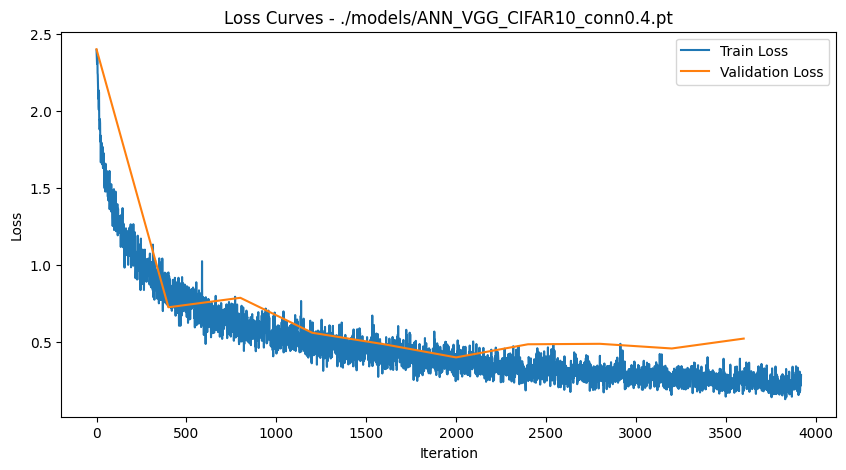

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 86.72%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.41
Validation loss: 2.40
Validation accuracy: 10.55%
Training accuracy: 5.86%
----------------
Iteration: 400
Training loss: 0.77
Validation loss: 0.76
Validation accuracy: 73.83%
Training accuracy: 75.00%
----------------
Iteration: 800
Training loss: 0.63
Validation loss: 0.61
Validation accuracy: 78.12%
Training accuracy: 76.95%
----------------
Iteration: 1200
Training loss: 0.63
Validation loss: 0.58
Validation accuracy: 79.69%
Training accuracy: 82.42%
----------------
Iteration: 1600
Training loss: 0.33
Validation loss: 0.51
Validation accuracy: 81.64%
Training accuracy: 88.67%
----------------
Iteration: 2000
Training loss: 0.40
Validation loss: 0.42
Validation accuracy: 83.59%
Training accuracy: 87.50%
----------------
Iteration: 2400
Training loss: 0.32
Validation loss: 0.57
Validation accuracy: 80.86%
Training accuracy: 88.67%
----------------
Iteration: 2800
Training loss: 0.37
Validation loss: 0.57
Validation accuracy: 81.64%
Training accuracy

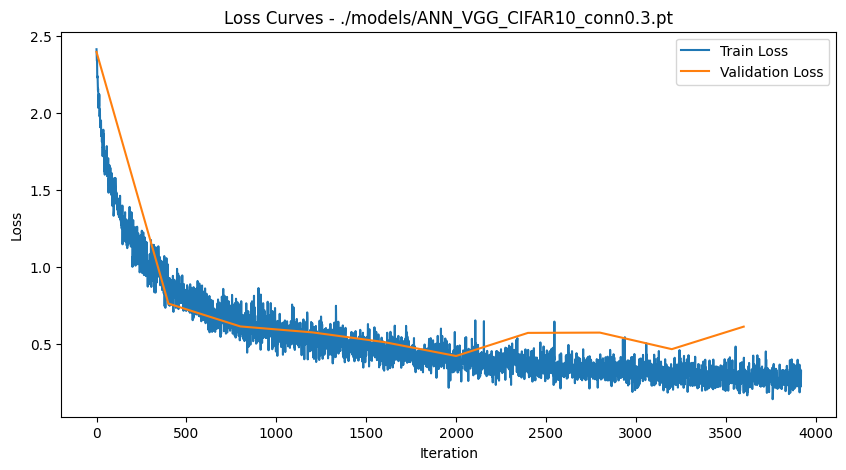

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 86.04%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 8.98%
Training accuracy: 12.89%
----------------
Iteration: 400
Training loss: 0.94
Validation loss: 1.02
Validation accuracy: 66.41%
Training accuracy: 68.75%
----------------
Iteration: 800
Training loss: 0.68
Validation loss: 0.71
Validation accuracy: 76.56%
Training accuracy: 76.17%
----------------
Iteration: 1200
Training loss: 0.49
Validation loss: 0.76
Validation accuracy: 77.73%
Training accuracy: 87.11%
----------------
Iteration: 1600
Training loss: 0.51
Validation loss: 0.59
Validation accuracy: 80.08%
Training accuracy: 82.42%
----------------
Iteration: 2000
Training loss: 0.48
Validation loss: 0.56
Validation accuracy: 83.20%
Training accuracy: 83.20%
----------------
Iteration: 2400
Training loss: 0.37
Validation loss: 0.57
Validation accuracy: 82.03%
Training accuracy: 85.55%
----------------
Iteration: 2800
Training loss: 0.44
Validation loss: 0.63
Validation accuracy: 76.95%
Training accuracy

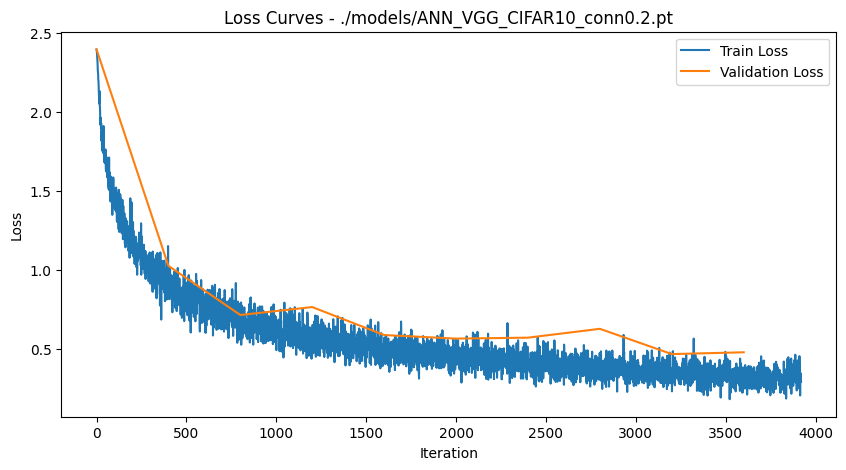

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 84.73%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 8.20%
Training accuracy: 10.94%
----------------
Iteration: 400
Training loss: 1.01
Validation loss: 1.17
Validation accuracy: 62.50%
Training accuracy: 63.28%
----------------
Iteration: 800
Training loss: 0.82
Validation loss: 0.82
Validation accuracy: 72.66%
Training accuracy: 73.44%
----------------
Iteration: 1200
Training loss: 0.70
Validation loss: 0.70
Validation accuracy: 80.08%
Training accuracy: 80.08%
----------------
Iteration: 1600
Training loss: 0.61
Validation loss: 0.71
Validation accuracy: 77.73%
Training accuracy: 79.30%
----------------
Iteration: 2000
Training loss: 0.48
Validation loss: 0.55
Validation accuracy: 80.86%
Training accuracy: 85.94%
----------------
Iteration: 2400
Training loss: 0.58
Validation loss: 0.59
Validation accuracy: 82.03%
Training accuracy: 80.47%
----------------
Iteration: 2800
Training loss: 0.53
Validation loss: 0.64
Validation accuracy: 81.64%
Training accuracy

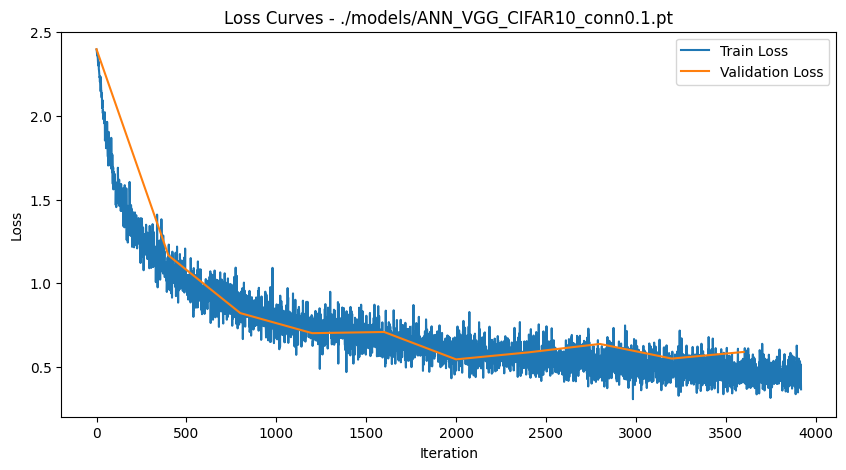

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 83.13%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 10.55%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 1.34
Validation loss: 1.15
Validation accuracy: 62.50%
Training accuracy: 53.12%
----------------
Iteration: 800
Training loss: 0.94
Validation loss: 0.87
Validation accuracy: 73.05%
Training accuracy: 70.70%
----------------
Iteration: 1200
Training loss: 0.61
Validation loss: 0.65
Validation accuracy: 77.73%
Training accuracy: 82.03%
----------------
Iteration: 1600
Training loss: 0.55
Validation loss: 0.68
Validation accuracy: 79.30%
Training accuracy: 81.25%
----------------
Iteration: 2000
Training loss: 0.56
Validation loss: 0.67
Validation accuracy: 78.52%
Training accuracy: 79.30%
----------------
Iteration: 2400
Training loss: 0.58
Validation loss: 0.71
Validation accuracy: 75.78%
Training accuracy: 81.25%
----------------
Iteration: 2800
Training loss: 0.44
Validation loss: 0.60
Validation accuracy: 81.64%
Training accuracy

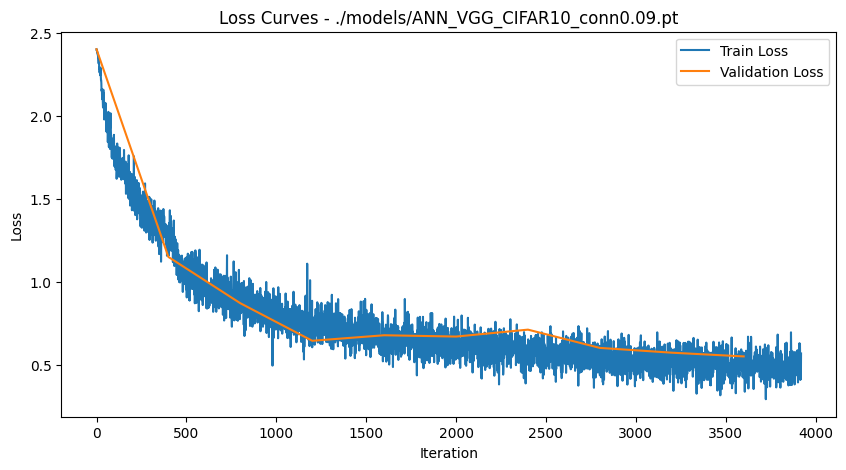

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 82.16%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 12.50%
Training accuracy: 12.89%
----------------
Iteration: 400
Training loss: 1.02
Validation loss: 1.15
Validation accuracy: 64.45%
Training accuracy: 68.36%
----------------
Iteration: 800
Training loss: 0.90
Validation loss: 0.94
Validation accuracy: 66.80%
Training accuracy: 71.48%
----------------
Iteration: 1200
Training loss: 0.73
Validation loss: 0.85
Validation accuracy: 70.70%
Training accuracy: 75.00%
----------------
Iteration: 1600
Training loss: 0.66
Validation loss: 0.83
Validation accuracy: 75.00%
Training accuracy: 77.34%
----------------
Iteration: 2000
Training loss: 0.65
Validation loss: 0.74
Validation accuracy: 75.78%
Training accuracy: 76.95%
----------------
Iteration: 2400
Training loss: 0.56
Validation loss: 0.66
Validation accuracy: 80.47%
Training accuracy: 80.08%
----------------
Iteration: 2800
Training loss: 0.57
Validation loss: 0.69
Validation accuracy: 74.61%
Training accurac

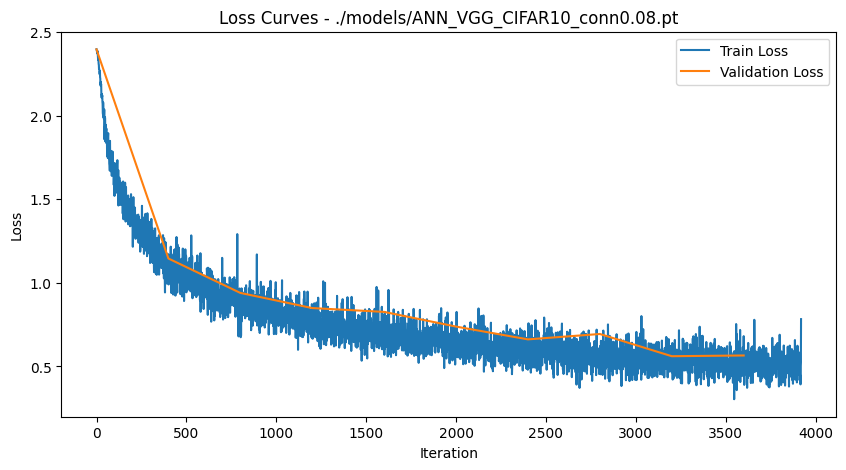

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 78.34%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 8.20%
Training accuracy: 13.28%
----------------
Iteration: 400
Training loss: 1.23
Validation loss: 0.99
Validation accuracy: 69.14%
Training accuracy: 57.81%
----------------
Iteration: 800
Training loss: 1.00
Validation loss: 0.71
Validation accuracy: 76.95%
Training accuracy: 67.58%
----------------
Iteration: 1200
Training loss: 0.72
Validation loss: 0.82
Validation accuracy: 75.39%
Training accuracy: 78.91%
----------------
Iteration: 1600
Training loss: 0.62
Validation loss: 0.80
Validation accuracy: 72.66%
Training accuracy: 79.30%
----------------
Iteration: 2000
Training loss: 0.80
Validation loss: 0.59
Validation accuracy: 80.86%
Training accuracy: 76.95%
----------------
Iteration: 2400
Training loss: 0.56
Validation loss: 0.65
Validation accuracy: 77.73%
Training accuracy: 81.64%
----------------
Iteration: 2800
Training loss: 0.51
Validation loss: 0.75
Validation accuracy: 78.12%
Training accuracy

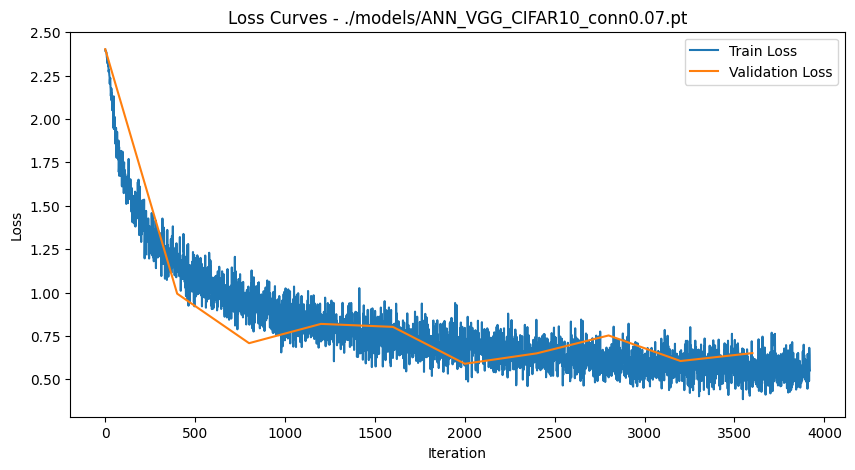

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 80.81%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.77%
Training accuracy: 10.55%
----------------
Iteration: 400
Training loss: 1.74
Validation loss: 1.94
Validation accuracy: 36.72%
Training accuracy: 42.58%
----------------
Iteration: 800
Training loss: 1.54
Validation loss: 1.52
Validation accuracy: 53.52%
Training accuracy: 51.17%
----------------
Iteration: 1200
Training loss: 1.46
Validation loss: 1.43
Validation accuracy: 60.55%
Training accuracy: 52.34%
----------------
Iteration: 1600
Training loss: 1.43
Validation loss: 1.38
Validation accuracy: 58.20%
Training accuracy: 54.69%
----------------
Iteration: 2000
Training loss: 1.32
Validation loss: 1.35
Validation accuracy: 55.47%
Training accuracy: 55.86%
----------------
Iteration: 2400
Training loss: 1.20
Validation loss: 1.59
Validation accuracy: 51.56%
Training accuracy: 66.41%
----------------
Iteration: 2800
Training loss: 1.32
Validation loss: 1.33
Validation accuracy: 57.81%
Training accuracy

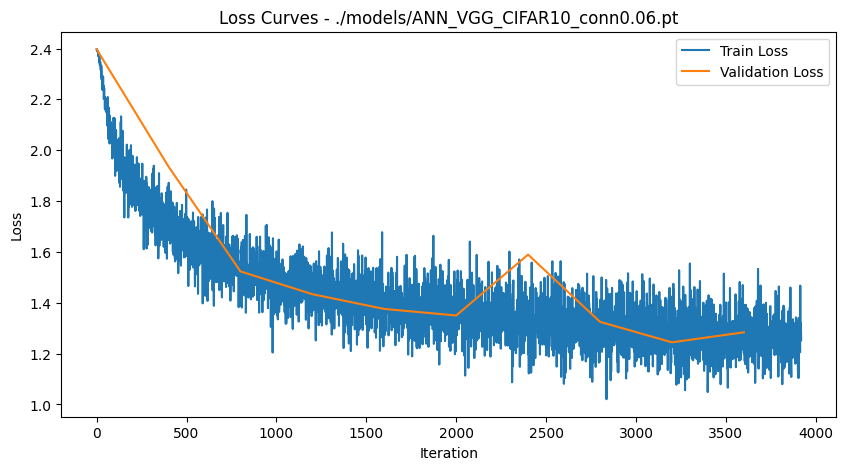

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 60.26%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 10.55%
Training accuracy: 8.98%
----------------
Iteration: 400
Training loss: 1.39
Validation loss: 1.72
Validation accuracy: 50.00%
Training accuracy: 58.20%
----------------
Iteration: 800
Training loss: 1.07
Validation loss: 1.25
Validation accuracy: 61.33%
Training accuracy: 64.84%
----------------
Iteration: 1200
Training loss: 1.08
Validation loss: 1.05
Validation accuracy: 66.80%
Training accuracy: 66.80%
----------------
Iteration: 1600
Training loss: 0.99
Validation loss: 0.92
Validation accuracy: 73.83%
Training accuracy: 69.14%
----------------
Iteration: 2000
Training loss: 0.93
Validation loss: 1.03
Validation accuracy: 67.97%
Training accuracy: 71.88%
----------------
Iteration: 2400
Training loss: 0.97
Validation loss: 0.99
Validation accuracy: 71.88%
Training accuracy: 69.14%
----------------
Iteration: 2800
Training loss: 0.99
Validation loss: 0.89
Validation accuracy: 70.31%
Training accuracy

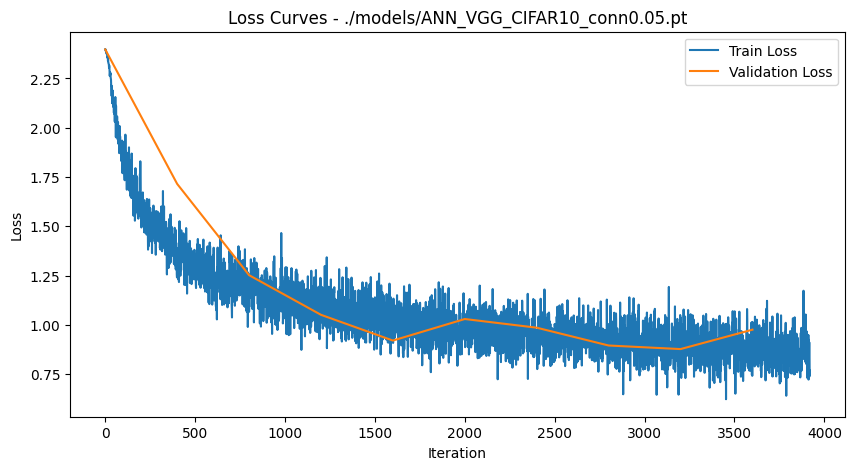

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 71.88%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 7.42%
Training accuracy: 8.59%
----------------
Iteration: 400
Training loss: 1.62
Validation loss: 1.55
Validation accuracy: 51.56%
Training accuracy: 44.92%
----------------
Iteration: 800
Training loss: 1.37
Validation loss: 1.54
Validation accuracy: 51.17%
Training accuracy: 57.81%
----------------
Iteration: 1200
Training loss: 1.17
Validation loss: 1.20
Validation accuracy: 59.38%
Training accuracy: 60.94%
----------------
Iteration: 1600
Training loss: 1.15
Validation loss: 1.14
Validation accuracy: 64.45%
Training accuracy: 63.28%
----------------
Iteration: 2000
Training loss: 1.03
Validation loss: 1.42
Validation accuracy: 53.52%
Training accuracy: 66.80%
----------------
Iteration: 2400
Training loss: 1.11
Validation loss: 1.22
Validation accuracy: 64.06%
Training accuracy: 63.28%
----------------
Iteration: 2800
Training loss: 1.13
Validation loss: 1.25
Validation accuracy: 58.20%
Training accuracy:

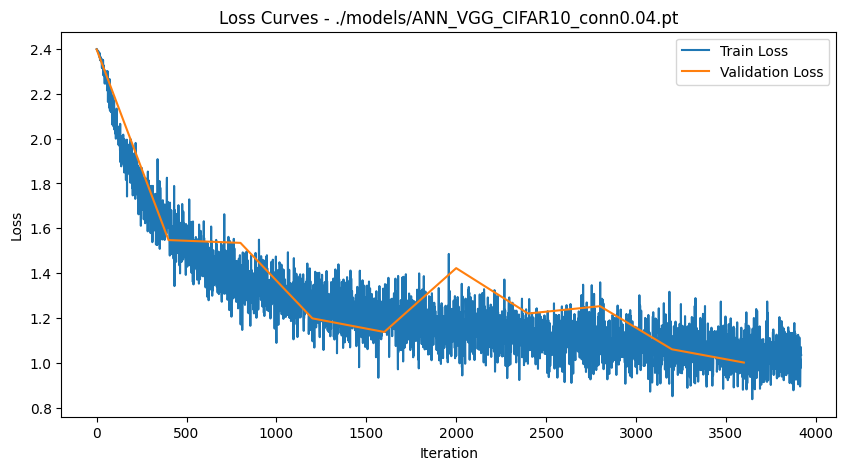

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 66.49%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.39
Validation loss: 2.40
Validation accuracy: 12.89%
Training accuracy: 13.67%
----------------
Iteration: 400
Training loss: 1.56
Validation loss: 2.75
Validation accuracy: 23.83%
Training accuracy: 51.17%
----------------
Iteration: 800
Training loss: 1.31
Validation loss: 1.69
Validation accuracy: 44.92%
Training accuracy: 56.25%
----------------
Iteration: 1200
Training loss: 1.29
Validation loss: 1.36
Validation accuracy: 54.69%
Training accuracy: 56.25%
----------------
Iteration: 1600
Training loss: 1.15
Validation loss: 2.49
Validation accuracy: 29.69%
Training accuracy: 59.38%
----------------
Iteration: 2000
Training loss: 1.11
Validation loss: 1.00
Validation accuracy: 67.19%
Training accuracy: 62.89%
----------------
Iteration: 2400
Training loss: 1.01
Validation loss: 1.84
Validation accuracy: 40.62%
Training accuracy: 67.97%
----------------
Iteration: 2800
Training loss: 1.00
Validation loss: 1.60
Validation accuracy: 56.25%
Training accurac

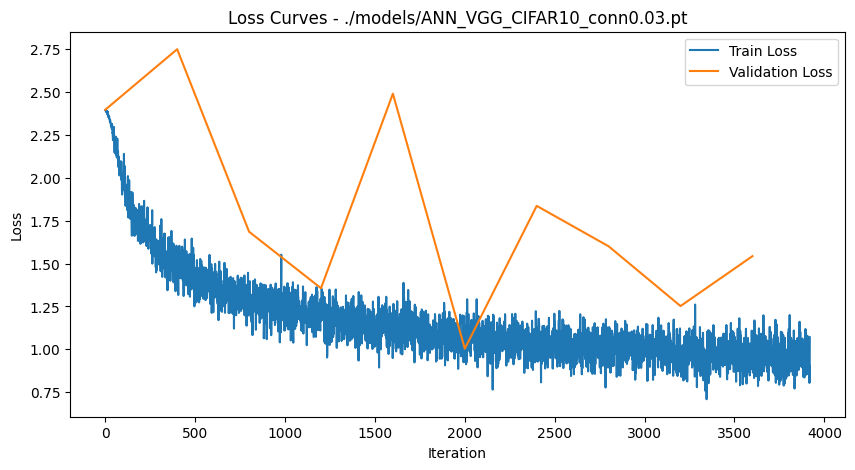

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 57.31%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.39
Validation loss: 2.39
Validation accuracy: 14.45%
Training accuracy: 10.94%
----------------
Iteration: 400
Training loss: 1.86
Validation loss: 2.35
Validation accuracy: 25.39%
Training accuracy: 36.72%
----------------
Iteration: 800
Training loss: 1.58
Validation loss: 2.99
Validation accuracy: 23.05%
Training accuracy: 50.78%
----------------
Iteration: 1200
Training loss: 1.59
Validation loss: 1.95
Validation accuracy: 32.81%
Training accuracy: 52.73%
----------------
Iteration: 1600
Training loss: 1.64
Validation loss: 2.20
Validation accuracy: 32.42%
Training accuracy: 47.66%
----------------
Iteration: 2000
Training loss: 1.53
Validation loss: 1.65
Validation accuracy: 46.48%
Training accuracy: 50.00%
----------------
Iteration: 2400
Training loss: 1.41
Validation loss: 1.99
Validation accuracy: 43.36%
Training accuracy: 54.30%
----------------
Iteration: 2800
Training loss: 1.49
Validation loss: 1.58
Validation accuracy: 46.88%
Training accurac

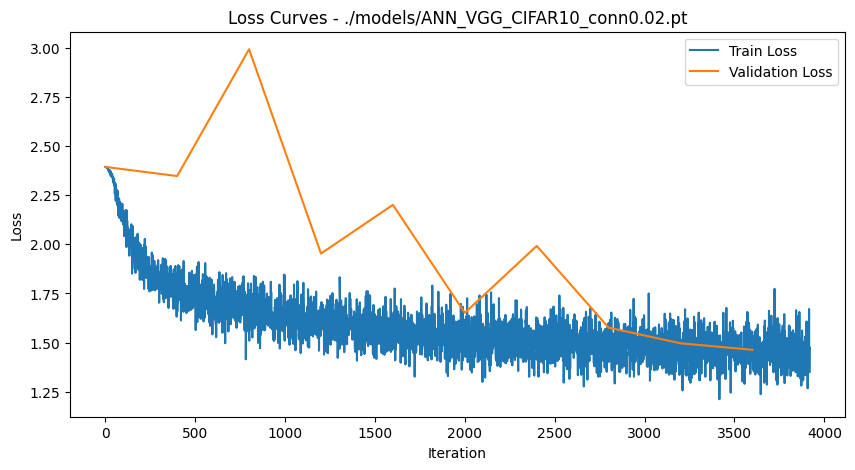

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 47.46%


Training progress::   0%|          | 0/3920 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 8.98%
Training accuracy: 8.20%
----------------
Iteration: 400
Training loss: 2.08
Validation loss: 8.72
Validation accuracy: 10.94%
Training accuracy: 29.69%
----------------
Iteration: 800
Training loss: 2.11
Validation loss: 10.94
Validation accuracy: 6.25%
Training accuracy: 30.86%
----------------
Iteration: 1200
Training loss: 2.06
Validation loss: 2.66
Validation accuracy: 16.80%
Training accuracy: 33.20%
----------------
Iteration: 1600
Training loss: 1.99
Validation loss: 10.17
Validation accuracy: 9.38%
Training accuracy: 32.81%
----------------
Iteration: 2000
Training loss: 2.05
Validation loss: 3.68
Validation accuracy: 10.55%
Training accuracy: 31.25%
----------------
Iteration: 2400
Training loss: 1.91
Validation loss: 4.86
Validation accuracy: 11.72%
Training accuracy: 35.55%
----------------
Iteration: 2800
Training loss: 1.99
Validation loss: 5.68
Validation accuracy: 10.94%
Training accuracy:

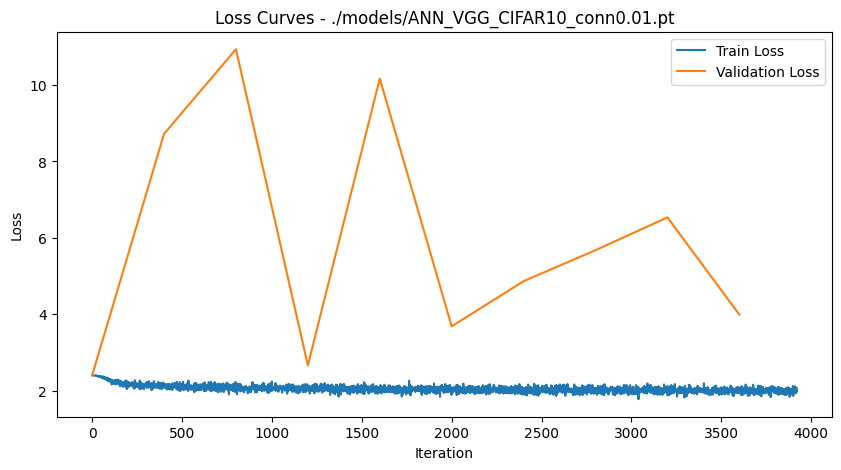

Testing progress::   0%|          | 0/40 [00:00<?, ?it/s]

Test Accuracy: 11.41%


In [4]:
model_path = "./models/ANN_VGG_CIFAR10.pt"
net = Net()
optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
gen_reset() #reset the PRNG generators for the random samplers so we consistently get the same sequence of samples for each experiment run
net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=20,valid_after=400,deepr=False,device=device)
gen_reset()
baseline_accuracy = test_stats(net,test_loader=test_loader,device=device)
print("----")

connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]

accuracies = []

for c in connectivities:
    model_path = "./models/ANN_VGG_CIFAR10_conn"+str(c)+".pt"
    net = Net(c)
    optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
    gen_reset()
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=20,valid_after=400,deepr=True,device=device)
    gen_reset()
    a = test_stats(net,test_loader=test_loader,device=device)
    accuracies.append(a)

with open("./pickles/ANN_VGG_CIFAR10_baseline", "wb") as f:
    pickle.dump(baseline_accuracy,f)

with open("./pickles/ANN_VGG_CIFAR10_accuracies", "wb") as f:
    pickle.dump(accuracies,f)

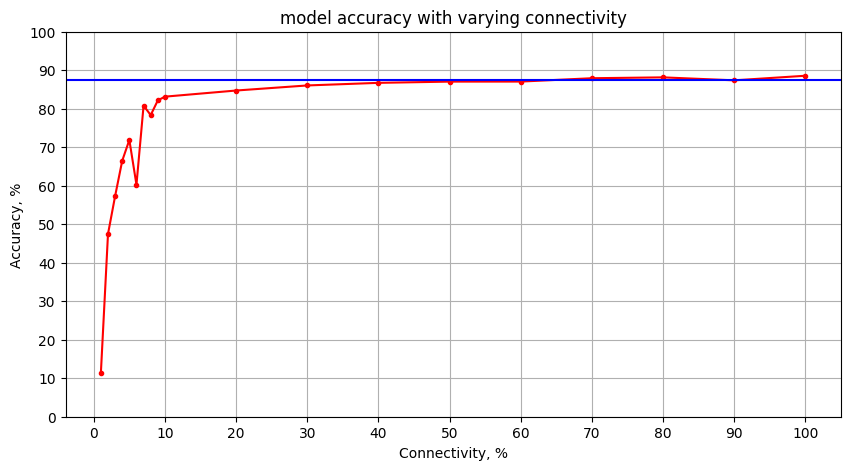

In [5]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],[a*100 for a in accuracies],'.r-')
plt.axhline(y = baseline_accuracy*100, color = 'b', linestyle = '-')
plt.title("model accuracy with varying connectivity")
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy, %")
plt.xticks(range(0,101,10))
plt.yticks(range(0,101,10))
plt.grid(True)
plt.show()